In [1]:
import random
import itertools

import chat as chat
import data as data
import utility as util

In [2]:
# Import our data -- the load_challenge_moves_csv function also processes the csv load so move / win probability are lists rather than strings
train_df = data.loader.load_challenge_moves_csv("data/chess_challenges_train_10k.csv", shuffle=True)

train_iterator = itertools.cycle(train_df.iterrows())

In [3]:
def evaluate_chess_model(ollama_session, train_iterator, board_representation, move_representation, with_piece, max_iters=None, max_timeout=30, verbose=False):
    evaluation_results = {
        "num_attempts": 0,
        "num_predicted": [],
        "num_actual": [],
        "num_correct": [],
        "num_illegal": [],
        "num_missed": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "error_timeout": 0,
        "error_generation": 0,
        "error_extraction": 0,
    }
    system_prompt = chat.generate_chess_system_prompt(board_representation, move_representation, with_piece)
    print("SYSTEM PROMPT")
    print(system_prompt)
    for iter in range(max_iters):
        evaluation_results["num_attempts"] += 1
        try:
            _, row = next(train_iterator)
            board = row["FEN"]
            util.visualize_board_ipynb(row["FEN"])
            print("BOARD", board)
            piece_letter, piece_position = util.get_random_piece_and_position(board)
            print("PIECE")
            print(piece_letter, piece_position)
            legal_moves = util.get_legal_moves(board, piece_position, move_representation)
            print("LEGAL MOVES")
            print(legal_moves)
            prompt = chat.format_prompt_for_legal_move(board, board_representation, piece_letter, piece_position, move_representation)
            print("PROMPT")
            print(prompt)
            # Generate a response from the model
            response, runtime_results = ollama_session.chat_baseline(system_prompt = system_prompt, user_prompt=prompt, timeout=max_timeout)
            print("RESPONSE")
            print(response)
            moves = chat.extract_legal_moves(response)
            print("MOVES")
            print(moves)
            if verbose:
                print(f"{'-'*100}\nPrompt:\n{prompt}\n\nResponse:\n{response}\n\nRuntime Results:\n{runtime_results}\n{'-'*100}\n")
                util.visualize_board_ipynb(row["FEN"])
                print(moves)

            correct_moves, missed_moves, illegal_moves = util.compare_moves_and_legal_moves(moves, legal_moves)
            
            #update evaluation results
            num_predicted = len(moves)
            num_actual = len(legal_moves)
            num_correct = len(correct_moves)
            num_illegal = len(illegal_moves)
            num_missed = len(missed_moves)
            precision = num_correct / num_predicted if num_predicted > 0 else 0
            recall = num_correct / num_actual if num_actual > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            evaluation_results["num_predicted"].append(num_predicted)
            evaluation_results["num_actual"].append(num_actual)
            evaluation_results["num_correct"].append(num_correct)
            evaluation_results["num_illegal"].append(num_illegal)
            evaluation_results["num_missed"].append(num_missed)
            evaluation_results["precision"].append(precision)
            evaluation_results["recall"].append(recall)
            evaluation_results["f1_score"].append(f1_score)
            tps = runtime_results["generated_tokens"] / runtime_results["generation_duration"]
            print(f"[{iter+1:<4}/{max_iters:<4}] Move: {moves} | Correct Ratio: {len(correct_moves)} / {len(legal_moves)} | Illegal Raio: {len(illegal_moves)} / {len(moves)} | TPS: {tps:.2f}")

        except Exception as e:
            print(f"[{iter+1:<4}/{max_iters:<4}] {type(e).__name__}: {e}")
            if type(e) == chat.TimeoutError:
                evaluation_results["error_timeout"] += 1
            elif type(e) == chat.GenerationError:
                evaluation_results["error_generation"] += 1
            elif type(e) == chat.ExtractionError:
                evaluation_results["error_extraction"] += 1
            else:
                print(f"Unknown Error: {e}")

    # At end print out results
    # Compute aggregate statistics
    total_attempts = evaluation_results["num_attempts"]
    avg_precision = sum(evaluation_results["precision"]) / total_attempts
    avg_recall = sum(evaluation_results["recall"]) / total_attempts
    avg_f1_score = sum(evaluation_results["f1_score"]) / total_attempts
    # overall_accuracy = sum(evaluation_results["num_correct"]) / sum(evaluation_results["num_actual"])

    print(f"\n{'='*60}\nEvaluation Summary:")
    print(f"Total Attempts: {total_attempts}")
    print(f"Avg Precision: {avg_precision:.4f}")
    print(f"Avg Recall: {avg_recall:.4f}")
    print(f"Avg F1 Score: {avg_f1_score:.4f}")
    # print(f"Overall Accuracy: {overall_accuracy:.4f}")

    return evaluation_results

SYSTEM PROMPT
You are a smart, strategic, and wise chess reasoning model looking for the legal moves to move a piece.
The board state is provided in Forsyth-Edwards Notation (FEN), a standard notation for describing a chess position.
Given a specific piece type and position on the board, analyze the position carefully.
Your task is to determine and provide **all valid moves** for the given piece in the current board state.
The type of chess piece is specified within the <piece> </piece> tag and its position within the <position> </position> tag.Moves should be formatted in Standard Algebraic Notation (SAN) format.
Think through your reasoning within <think> tags before arriving at the final answer.
The final list of moves should be enclosed within <answer> tags.
If there are no moves possible don't populate anything between the <answer> tags.

For example, when given an input prefixed with "user:", your response should be in the format "assistant: <think> [your reasoning] </think> <ans

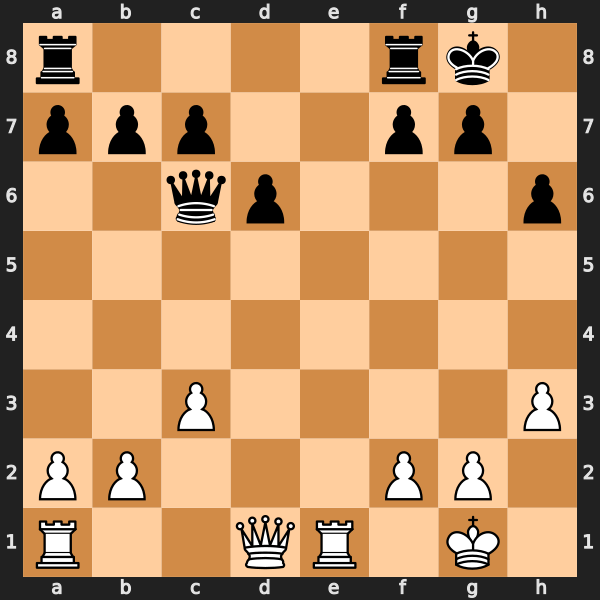

BOARD r4rk1/ppp2pp1/2qp3p/8/8/2P4P/PP3PP1/R2QR1K1 b - - 1 17
PIECE
r f8
LEGAL MOVES
['Rfe8', 'Rfd8', 'Rfc8', 'Rfb8']
PROMPT
<board> 
r4rk1/ppp2pp1/2qp3p/8/8/2P4P/PP3PP1/R2QR1K1 b - - 1 17
</board>
 <piece> r </piece> <position> f8 </position>
The legal moves are expected in SAN format
RESPONSE
<think>
Alright, I'm trying to figure out all the valid moves for the 'r' piece on the given chess position. The board state provided is:

<board>
r4rk1/ppp2pp1/2qp3p/8/8/2P4P/PP3PP1/R2QR1K1 b - - 1 17
</board>

And the specific piece is 'r' with its position in the <position> tag being f8.

First, I need to understand where the 'r' is. The notation is r4rk1/ppp2pp1/... which indicates that the rook (r) has an initial position of r4k1. So, the rook is on rank 4, and the file it's on could be any of the files involved in the rook move.

The current position is f8. In standard chess notation, a rook can move any number of squares along its file or rank. Since it's already on f8, it has some availab

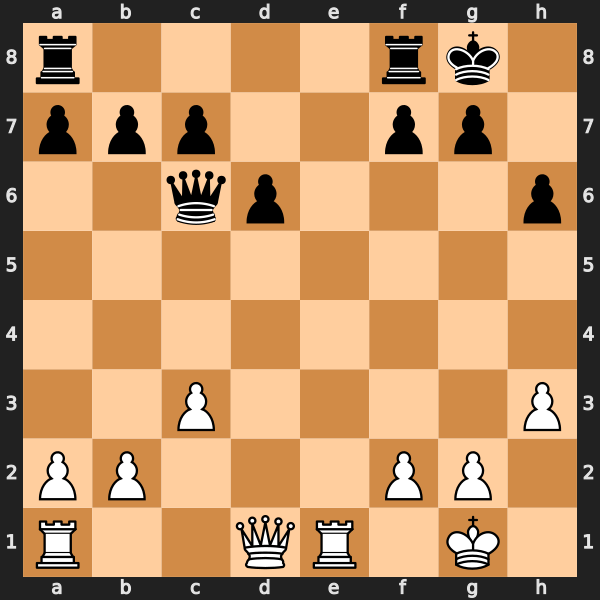

['e4', 'd4', 'c4', 'b4', 'a4']
[1   /5   ] Move: ['e4', 'd4', 'c4', 'b4', 'a4'] | Correct Ratio: 0 / 4 | Illegal Raio: 5 / 5 | TPS: 57.32


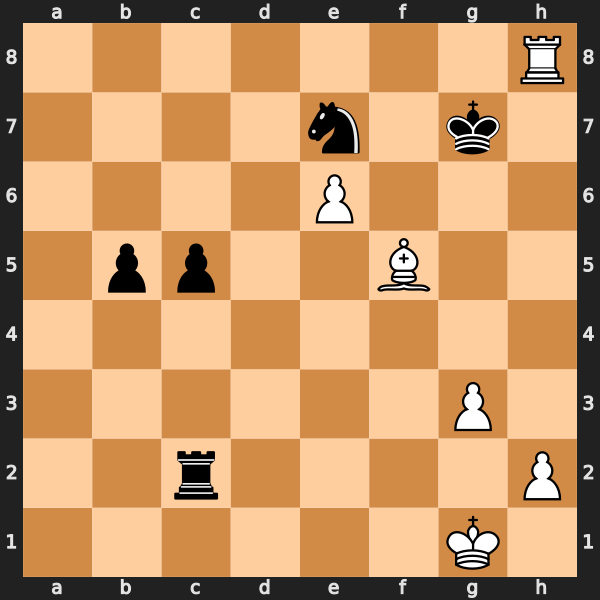

BOARD 7R/4n1k1/4P3/1pp2B2/8/6P1/2r4P/6K1 w - - 3 50
PIECE
R h8
LEGAL MOVES
['Rg8+', 'Rf8', 'Re8', 'Rd8', 'Rc8', 'Rb8', 'Ra8', 'Rh7+', 'Rh6', 'Rh5', 'Rh4', 'Rh3']
PROMPT
<board> 
7R/4n1k1/4P3/1pp2B2/8/6P1/2r4P/6K1 w - - 3 50
</board>
 <piece> R </piece> <position> h8 </position>
The legal moves are expected in SAN format
RESPONSE
<think>
Okay, I need to figure out all the valid moves for a rook (R) on this specific chess position. Let me start by understanding the given FEN notation and then break it down step by step.

First, the FEN is: 7R/4n1k1/4P3/1pp2B2/8/6P1/2r4P/6K1 w - - 3 50. The rook is on h8. I know that in chess notation, each square can be represented by a letter (for columns) and a number (for rows), so h8 would translate to column H, row 8.

The possible moves for a rook are any squares along the same rank (row) or file (column). So, from h8, the rook could move vertically up to the second rank or horizontally left to column a or right to column g in row 8.

But I also ne

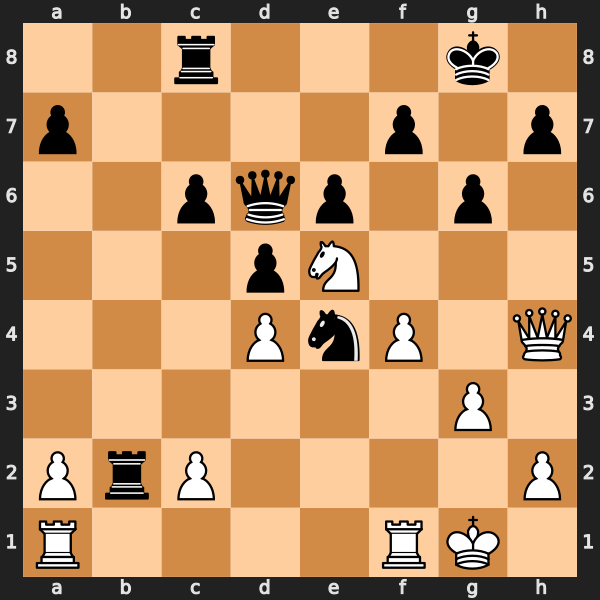

BOARD 2r3k1/p4p1p/2pqp1p1/3pN3/3PnP1Q/6P1/PrP4P/R4RK1 b - - 1 22
PIECE
n e4
LEGAL MOVES
['Nf6', 'Ng5', 'Nc5', 'Nxg3', 'Nc3', 'Nf2', 'Nd2']
PROMPT
<board> 
2r3k1/p4p1p/2pqp1p1/3pN3/3PnP1Q/6P1/PrP4P/R4RK1 b - - 1 22
</board>
 <piece> n </piece> <position> e4 </position>
The legal moves are expected in SAN format
RESPONSE
<think>
Okay, so I have to figure out all the valid moves for a knight on this chess position given by the FEN string. Let's break it down step by step.

First, looking at the board setup:
- The white king is on e4.
- There are multiple pieces around and some pawns in check.

The piece in question is 'n', which is the knight. I remember that knights move in an L-shape: two squares in one direction and then one square perpendicular to that, or vice versa.

Starting with the position 'e4'. Let's think about where a knight can move from there. The basic moves would be:
1. From e4, a knight could go to d6.
2. It could also move to f5.
3. Then it might try moving to g6.
4. Or

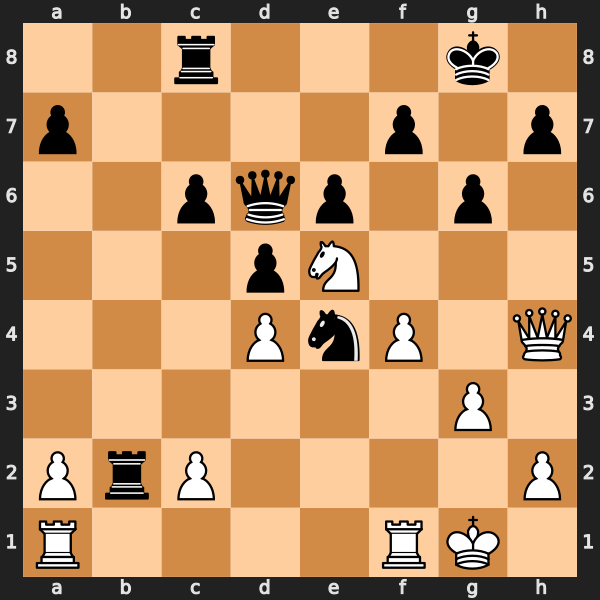

['c5', 'd6', 'f6']
[3   /5   ] Move: ['c5', 'd6', 'f6'] | Correct Ratio: 0 / 7 | Illegal Raio: 3 / 3 | TPS: 54.35


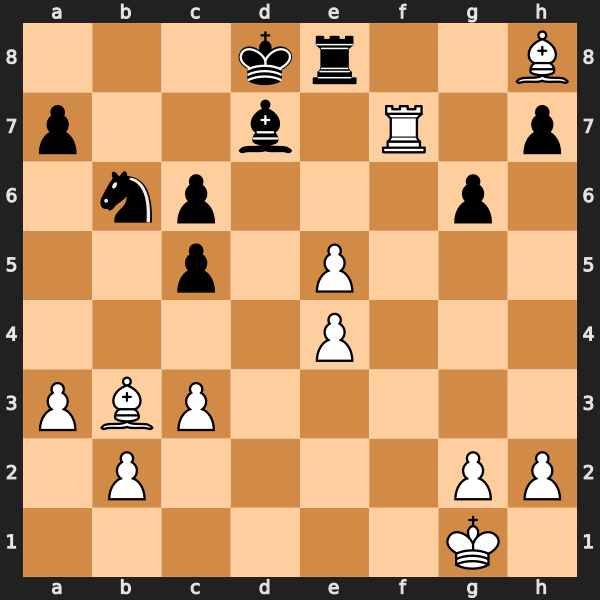

BOARD 3kr2B/p2b1R1p/1np3p1/2p1P3/4P3/PBP5/1P4PP/6K1 w - - 9 27
PIECE
P g2
LEGAL MOVES
['g3', 'g4']
PROMPT
<board> 
3kr2B/p2b1R1p/1np3p1/2p1P3/4P3/PBP5/1P4PP/6K1 w - - 9 27
</board>
 <piece> P </piece> <position> g2 </position>
The legal moves are expected in SAN format
RESPONSE
<think>
Alright, so I'm trying to figure out all the valid moves for a pawn (P) on the given chess position. The piece is currently on g2, which I think is one of the second rank pawns. Let me start by breaking down the FEN string provided.

The board is described as:
3kr2B/p2b1R1p/1np3p1/2p1P3/4P3/PBP5/1P4PP/6K1 w - - 9 27

This seems like a complex setup. I'm focusing on the pawn at g2. Let me analyze each component step by step.

First, I need to consider all possible moves for a pawn based on its current position and the rules of chess. Pawns can move forward one square or two squares from their starting position if certain conditions are met (like being blocked and promoting). 

Looking at the FEN string:
-

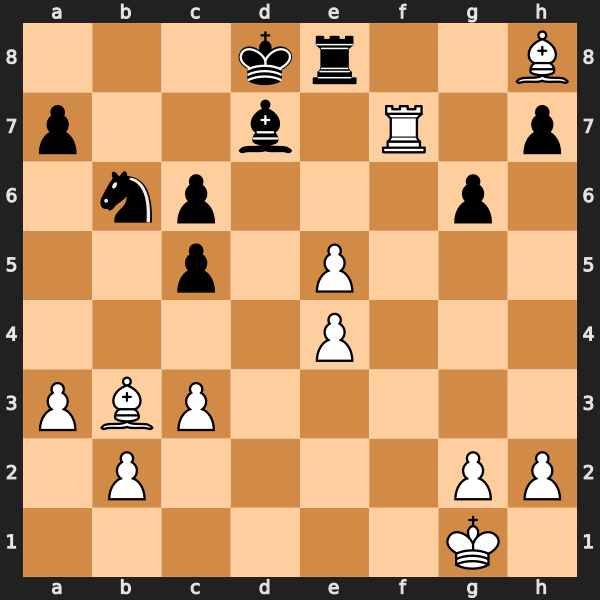

['e2', 'e3', 'd5']
[4   /5   ] Move: ['e2', 'e3', 'd5'] | Correct Ratio: 0 / 2 | Illegal Raio: 3 / 3 | TPS: 55.64


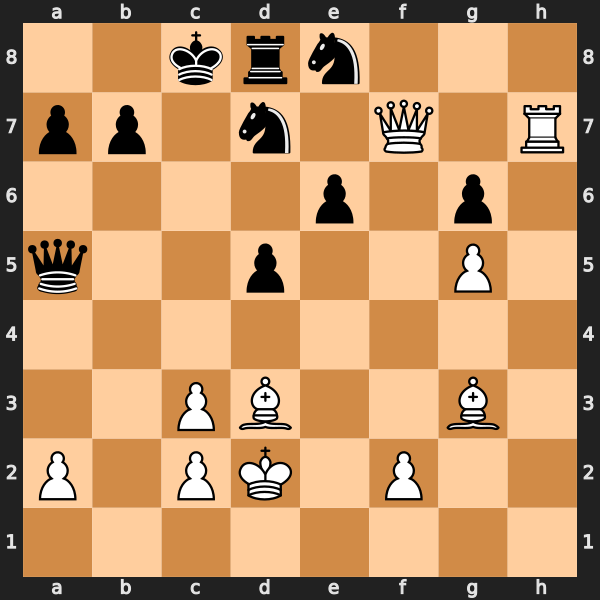

BOARD 2krn3/pp1n1Q1R/4p1p1/q2p2P1/8/2PB2B1/P1PK1P2/8 b - - 0 20
PIECE
n d7
LEGAL MOVES
['Nf8', 'Nb8', 'Ndf6', 'Nb6', 'Ne5', 'Nc5']
PROMPT
<board> 
2krn3/pp1n1Q1R/4p1p1/q2p2P1/8/2PB2B1/P1PK1P2/8 b - - 0 20
</board>
 <piece> n </piece> <position> d7 </position>
The legal moves are expected in SAN format


KeyboardInterrupt: 

In [4]:
# Create a new Ollama Session to allow us to chat w/ various models
# IMPORTANT: Make sure to call `ollama serve` in your terminal to start the Ollama server
# [Lucas]: I'm personally getting ~70TPS on 1.5b and ~7TPS on 7b on my laptop. Most responses are between 1000-2000 tokens.
model_name = "deepseek-r1:1.5b"       # {deepseek-r1:1.5b, deepseek-r1:7b}
board_rep = "grid" # {grid, desc, FEN}
ollama_session = chat.OllamaSession(model=model_name, use_cuda=False, board_representation= board_rep)

results = evaluate_chess_model(
    ollama_session = ollama_session, 
    train_iterator = train_iterator, 
    board_representation = board_rep,
    move_representation="PGN",
    with_piece=True,
    max_iters = 5,
    max_timeout = 60,
    verbose = True
)